In [1]:
import os
import random
import cv2
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [ ]:
# mndata = MNIST("rawdata")
# test_data = mndata.load_testing()
# for i,item in enumerate(zip(test_data[0],test_data[1])):

#     image,label = item
#     img = Image.fromarray(np.asarray(image).reshape((28,28))*255).resize((IMG_SIZE,IMG_SIZE))
#     img.save(f'data/test/img_{label}_{i}.png')

In [42]:
FOLDER = 'data'
BATCH_SIZE = 16
EPOCHS = 25
LR = 0.001
IMG_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

img_transform = transforms.Compose([
    transforms.RandomCrop(int(0.8*IMG_SIZE)),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomAffine(degrees=30,translate=(0.1,0.1),scale=(0.8,1.2)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5)),
])

In [43]:
class ImageDataset(Dataset):

    def __init__(self,folder,transform=None,test=False,display=None):
        
        self.folder = folder
        self.traintest = "test" if test else "train"
        self.data = os.listdir(f'data/{self.traintest}')
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])
        
        self.display = display
        
        if self.display != None:
            print(f'We will only be displaying the {self.display}th element.')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        
        if self.display != None:
            index = self.display
            
        item = self.data[index]
        label = int(item.split("_")[1])
        
        img = Image.open(f'data/{self.traintest}/{item}')
        
        
        if self.transform:
            image = self.transform(img)
        
        image = (image-image.min())/(image.max()-image.min())
        image = torch.where(image>0.5,1,0).float()
        
        return image, label

In [30]:
dataset = ImageDataset(FOLDER)#,transform=img_transform,display=0)

In [31]:
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


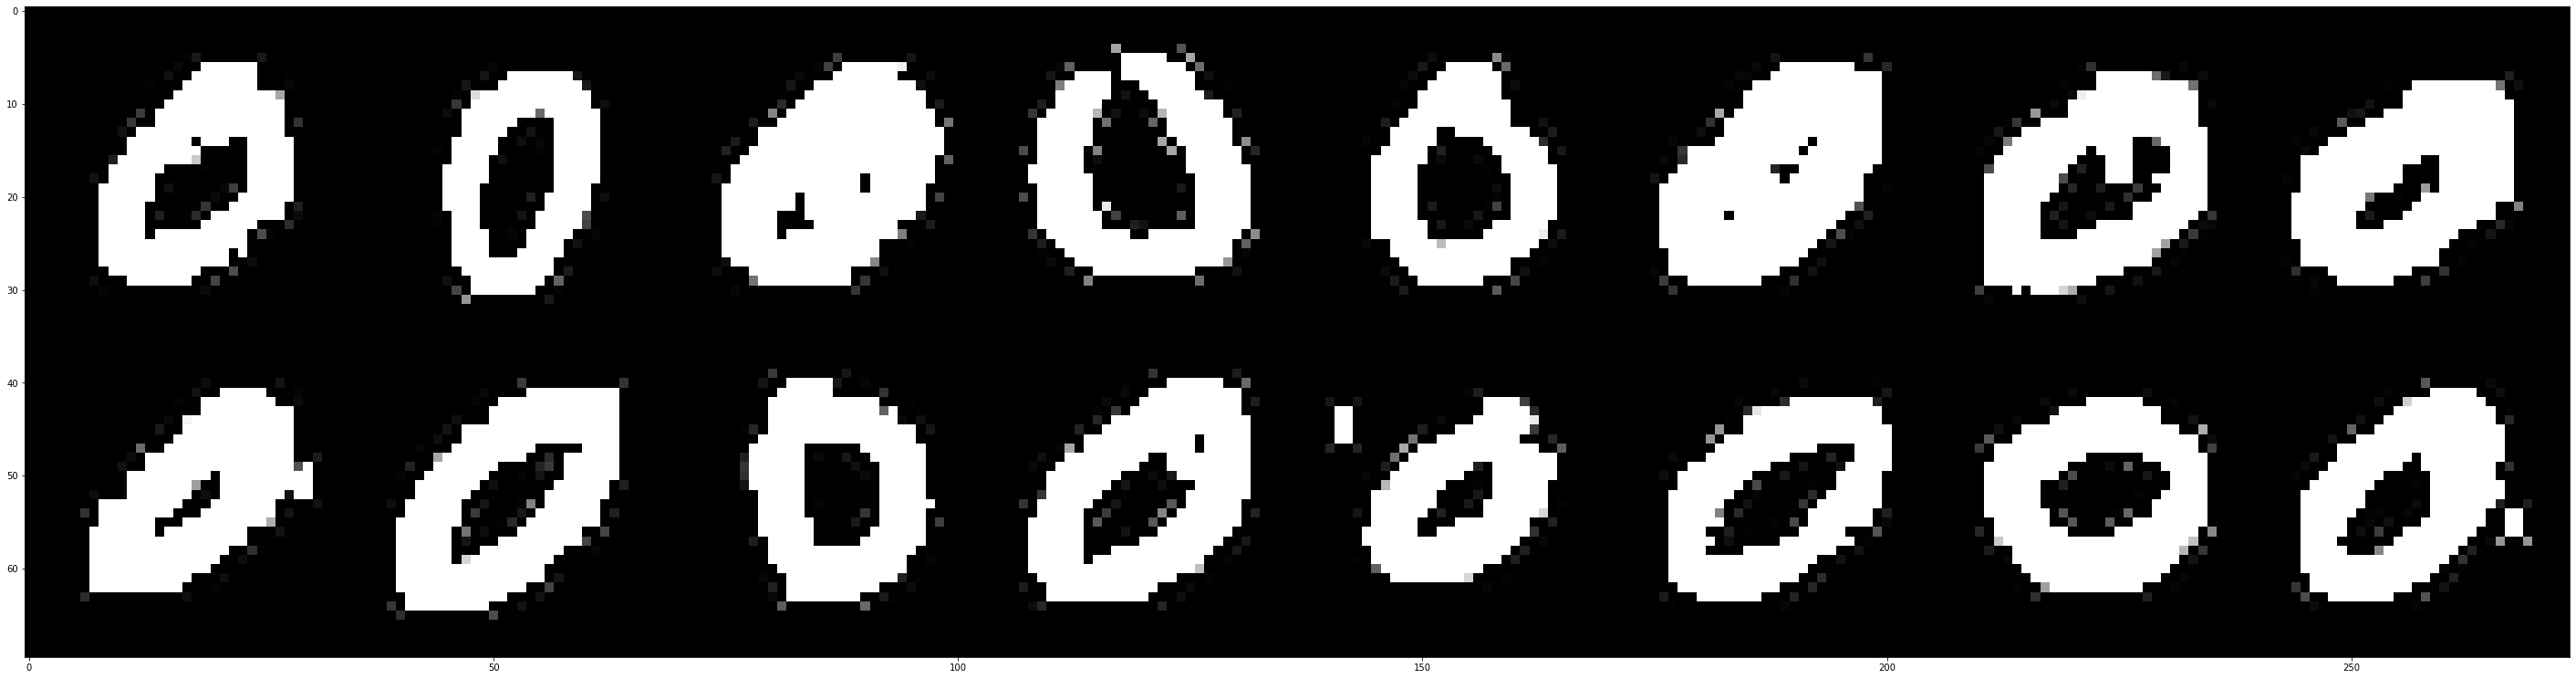

In [32]:
images,labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

In [34]:
np.unique(images)

array([    0,     1,     2, ..., 65527, 65529, 65535])

In [44]:
class Encoder(nn.Module):
    def __init__(self,channels,classes,latent_size,emb_size):
        super().__init__()     
        
        
        self.conv1 = nn.Conv2d(channels,64,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(64,2*latent_size,4,stride=2,padding=1)
        
        self.mp = nn.MaxPool2d(2,2)
        
        self.layer1 = nn.Linear(2*latent_size,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,emb_size)
        self.layer4 = nn.Linear(emb_size,classes)
         

    def forward(self, x):
        
        out = self.conv1(x)
        out = self.mp(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.mp(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.mp(out)
        out = F.relu(out)
        out= self.conv4(out)
        out = self.mp(out)
        out = F.relu(out).view(out.shape[0],-1)
        
        emb = F.relu(self.layer1(out))
        emb = F.relu(self.layer2(emb))
        emb = F.relu(self.layer3(emb))
        pred = self.layer4(emb)
        
        
        return out,emb,pred


In [45]:
class Decoder(nn.Module):
    def __init__(self,channels,latent_size,emb_size):
        super().__init__()     
        
        self.transconv1 = nn.ConvTranspose2d(latent_size+emb_size,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,channels,3,1,1)

        
    def forward(self,x,y):
        
        z = torch.cat([x,y],dim=1)

        out = self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out = self.transconv2(out)
        out = F.relu(out)
        out = self.transconv3(out)
        out = F.relu(out)
        out = self.transconv4(out)
        out = torch.sigmoid(out)

        return out


In [46]:
class iVAE(nn.Module):
    def __init__(self,channels,classes,latent_size,emb_size):
        super().__init__()
        
        self.encoder = Encoder(channels,classes,latent_size,emb_size)
        self.decoder = Decoder(channels,latent_size,emb_size)
        
    def forward(self,x,labels):
        
        h,emb,pred = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        s= torch.exp(logvar/2)
        eps = torch.randn_like(s)
        z = s*eps + mu 

        out = self.decoder(h[:,:64],emb)
    
        return out,mu,logvar,pred

In [47]:
dataset = ImageDataset(FOLDER)
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [12]:
def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)  - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    RL = F.mse_loss(recon_x,x)
    return RL + KLD

In [13]:
model = iVAE(1,10,64,32)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
ALPHA = 1

In [14]:
losses = []

for e in range(EPOCHS):
    total_loss = 0
    for images,labels in tqdm(dataloader):

        labels = labels.to(device)
        images = images.to(device)

        output,mu,logvar,predictions = model(images,labels)
        loss = loss_function(output,images,mu,logvar) + ALPHA*criterion(predictions,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        total_loss += loss.detach().cpu()
        
    print(f'Epoch {e}: {total_loss}')        
    losses.append(total_loss/len(dataloader))
 

  0%|                                                                                         | 0/3750 [00:00<?, ?it/s]

Epoch 0: 926.7881469726562


  0%|▎                                                                               | 12/3750 [00:00<01:07, 55.70it/s]

Epoch 1: 362.75433349609375


  0%|▏                                                                                | 7/3750 [00:00<01:00, 61.58it/s]

Epoch 2: 285.45428466796875


  0%|▏                                                                                | 7/3750 [00:00<00:57, 64.70it/s]

Epoch 3: 247.70724487304688


  0%|▏                                                                                | 7/3750 [00:00<00:59, 62.95it/s]

Epoch 4: 224.80702209472656


  0%|▏                                                                                | 6/3750 [00:00<01:03, 59.27it/s]

Epoch 5: 202.37954711914062


  0%|▏                                                                                | 7/3750 [00:00<01:01, 60.52it/s]

Epoch 6: 192.1543731689453


  0%|▏                                                                                | 7/3750 [00:00<00:59, 62.67it/s]

Epoch 7: 181.95582580566406


  0%|▏                                                                                | 7/3750 [00:00<00:58, 63.53it/s]

Epoch 8: 174.44317626953125


  0%|▏                                                                                | 7/3750 [00:00<00:58, 64.40it/s]

Epoch 9: 175.3203887939453


  0%|▏                                                                                | 6/3750 [00:00<01:11, 52.31it/s]

Epoch 10: 165.47030639648438


  0%|▏                                                                                | 7/3750 [00:00<00:59, 62.67it/s]

Epoch 11: 157.03448486328125


  0%|▏                                                                                | 6/3750 [00:00<01:10, 52.77it/s]

Epoch 12: 165.08084106445312


  0%|▏                                                                                | 6/3750 [00:00<01:09, 53.72it/s]

Epoch 13: 149.2451171875


  0%|▏                                                                                | 7/3750 [00:00<00:58, 63.52it/s]

Epoch 14: 155.74923706054688


  0%|▏                                                                                | 7/3750 [00:00<01:01, 61.04it/s]

Epoch 15: 149.14532470703125


  0%|▏                                                                                | 6/3750 [00:00<01:04, 58.41it/s]

Epoch 16: 150.43185424804688


  0%|▏                                                                                | 7/3750 [00:00<00:59, 63.24it/s]

Epoch 17: 148.4725341796875


  0%|▏                                                                                | 7/3750 [00:00<00:55, 67.50it/s]

Epoch 18: 147.65513610839844


  0%|▏                                                                                | 7/3750 [00:00<00:54, 68.14it/s]

Epoch 19: 139.73025512695312


  0%|▏                                                                                | 7/3750 [00:00<00:54, 68.14it/s]

Epoch 20: 141.93893432617188


  0%|▏                                                                                | 7/3750 [00:00<00:55, 67.50it/s]

Epoch 21: 141.18869018554688


  0%|▎                                                                               | 14/3750 [00:00<00:55, 67.63it/s]

Epoch 22: 141.7071533203125


  0%|▎                                                                               | 14/3750 [00:00<00:54, 69.01it/s]

Epoch 23: 133.46826171875


100%|██████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.47it/s]

Epoch 24: 141.93319702148438


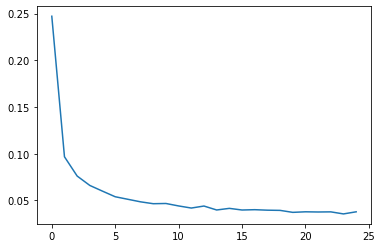

In [15]:
plt.plot(losses);

In [16]:
torch.save(model.state_dict(),"models/iVAE1.pkl")

In [48]:
model = iVAE(1,10,64,32).to("cuda")
model.load_state_dict(torch.load("models/iVAE1.pkl"))

<All keys matched successfully>

In [49]:
model = model.cpu()

In [50]:
testset = ImageDataset(FOLDER,test=True)
testloader = DataLoader(
    testset, 
    batch_size=200,
    shuffle=True
    )

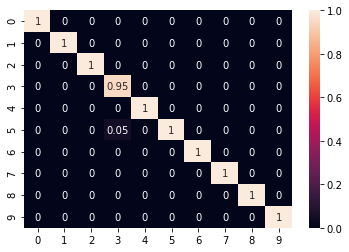

In [51]:
images,labels = next(iter(testloader))
with torch.no_grad():
    output,_,_,pred = model(images,labels)
sns.heatmap(confusion_matrix(labels,pred.argmax(dim=1),normalize="pred"),annot=True);

In [52]:
def custom_normalize(image):
    
    image = (image-image.min())/(image.max()-image.min())
    image = torch.where(image>0.5,1,0).float()
    
    return image

In [53]:
(labels!=pred.argmax(dim=1)).nonzero()

tensor([[39]])

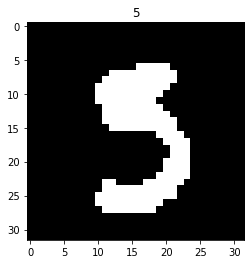

In [54]:
choice = 39
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

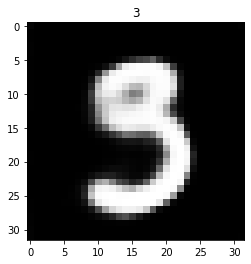

In [55]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

In [57]:
with torch.no_grad():
    output2,_,_,pred2 = model(custom_normalize(output),labels)

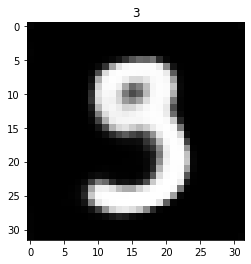

In [58]:
plt.imshow(output2[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred2[choice].argmax()}');

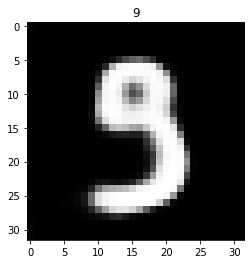

In [59]:
with torch.no_grad():
    output3,_,_,pred3 = model(custom_normalize(output2),labels)
    
plt.imshow(output3[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred3[choice].argmax()}');

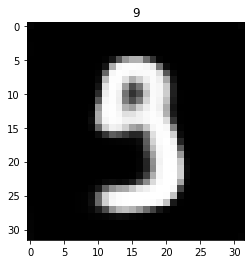

In [60]:
with torch.no_grad():
    output4,_,_,pred4 = model(custom_normalize(output3),labels)
    
plt.imshow(output4[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred4[choice].argmax()}');

In [40]:
labels

tensor([4, 7, 3, 6, 9, 9, 8, 4, 0, 0, 3, 4, 1, 0, 0, 5, 5, 0, 3, 3, 6, 6, 6, 2,
        5, 8, 9, 6, 7, 2, 6, 3, 5, 2, 9, 9, 8, 0, 2, 3, 5, 4, 4, 8, 5, 9, 5, 0,
        6, 7, 7, 4, 0, 2, 1, 9, 4, 4, 6, 2, 2, 2, 9, 1, 9, 1, 0, 2, 7, 7, 6, 4,
        2, 2, 0, 0, 7, 4, 1, 0, 3, 2, 9, 7, 3, 5, 5, 8, 9, 9, 1, 8, 9, 0, 7, 3,
        7, 9, 6, 1, 6, 6, 7, 8, 6, 6, 9, 7, 1, 0, 9, 5, 6, 3, 5, 4, 9, 9, 9, 4,
        6, 5, 9, 3, 9, 1, 9, 2, 3, 9, 4, 6, 1, 0, 1, 3, 7, 7, 4, 8, 4, 7, 2, 3,
        3, 1, 9, 2, 7, 1, 6, 9, 8, 6, 3, 1, 0, 1, 0, 4, 8, 9, 0, 2, 4, 4, 5, 4,
        7, 2, 5, 6, 9, 5, 9, 4, 9, 5, 0, 6, 4, 3, 0, 0, 7, 5, 7, 9, 9, 5, 5, 0,
        4, 5, 1, 6, 1, 3, 5, 1])

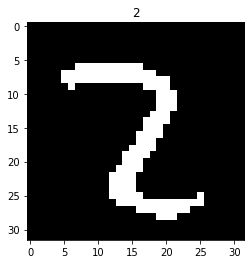

In [61]:
choice = 12
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

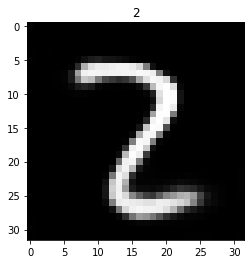

In [62]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

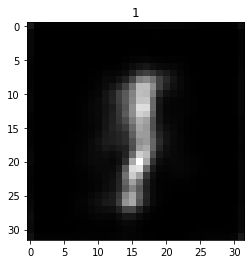

In [43]:
with torch.no_grad():
    output2,_,_,pred2 = model(output,labels)
    
plt.imshow(output2[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred2[choice].argmax()}');

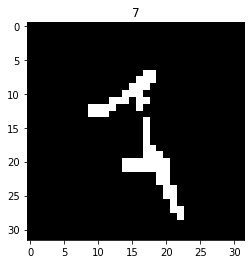

In [36]:
choice = 83
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

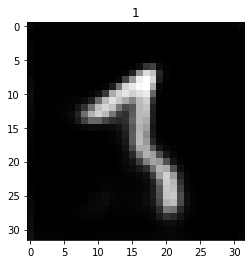

In [37]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

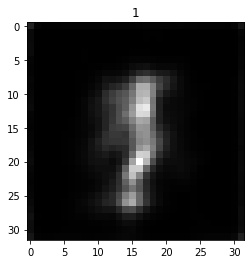

In [38]:
with torch.no_grad():
    output2,_,_,pred2 = model(output,labels)
    
plt.imshow(output2[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred2[choice].argmax()}');

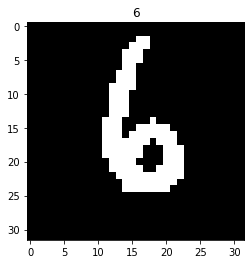

In [50]:
choice = 100
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

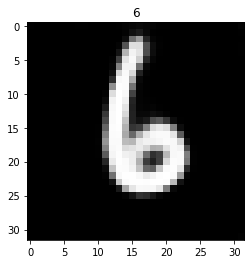

In [51]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

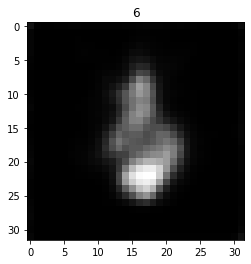

In [52]:
with torch.no_grad():
    output2,_,_,pred2 = model(output,labels)
    
plt.imshow(output2[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred2[choice].argmax()}');

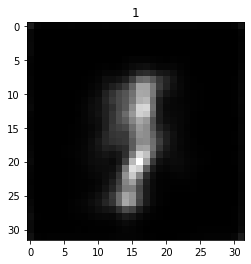

In [53]:
with torch.no_grad():
    output3,_,_,pred3 = model(output2,labels)
    
plt.imshow(output3[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred3[choice].argmax()}');

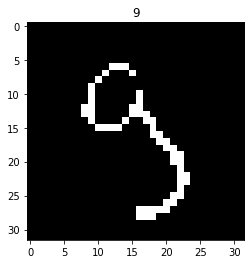

In [52]:
choice = 144
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

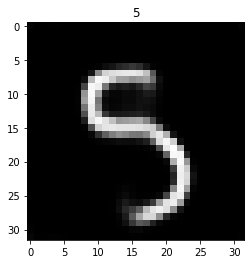

In [49]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

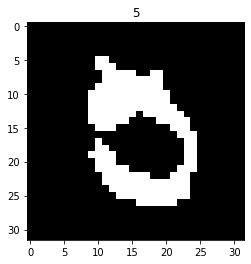

In [95]:
choice = 43
plt.imshow(images[choice].squeeze(),cmap="gray")
plt.title(f'{labels[choice]}');

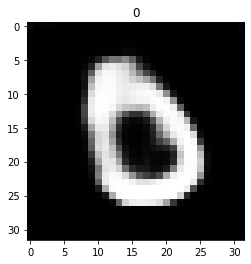

In [96]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")
plt.title(f'{pred[choice].argmax()}');

In [61]:
with torch.no_grad():
    output_test,_,_,pred_test = model(output,labels)


# for _ in range(1):
#     with torch.no_grad():
#         output_test,_,_,pred_test = model(output_test,labels)

In [62]:
torch.argmax(pred_test,dim=1)

tensor([4, 7, 1, 6, 9, 1, 1, 1, 0, 0, 3, 4, 1, 4, 0, 1, 5, 0, 3, 3, 6, 1, 6, 1,
        1, 1, 9, 6, 7, 1, 1, 3, 5, 1, 9, 9, 1, 0, 1, 3, 1, 4, 1, 1, 1, 9, 1, 1,
        1, 1, 7, 9, 0, 2, 1, 9, 4, 4, 6, 1, 1, 1, 9, 1, 1, 1, 0, 1, 7, 1, 6, 1,
        1, 1, 0, 0, 7, 4, 1, 0, 3, 1, 9, 1, 3, 1, 5, 1, 9, 9, 1, 8, 9, 1, 7, 3,
        1, 9, 6, 1, 6, 6, 7, 8, 6, 6, 9, 7, 1, 1, 9, 5, 6, 1, 3, 4, 1, 9, 1, 4,
        6, 1, 9, 1, 9, 1, 9, 2, 1, 1, 4, 1, 1, 1, 1, 3, 7, 1, 1, 1, 1, 1, 1, 3,
        1, 1, 9, 1, 7, 1, 6, 9, 8, 6, 1, 1, 0, 1, 0, 4, 8, 9, 0, 2, 1, 1, 1, 4,
        7, 1, 1, 1, 9, 1, 9, 4, 9, 5, 0, 6, 4, 3, 0, 0, 1, 5, 7, 9, 9, 5, 5, 0,
        4, 5, 1, 6, 1, 1, 1, 1])

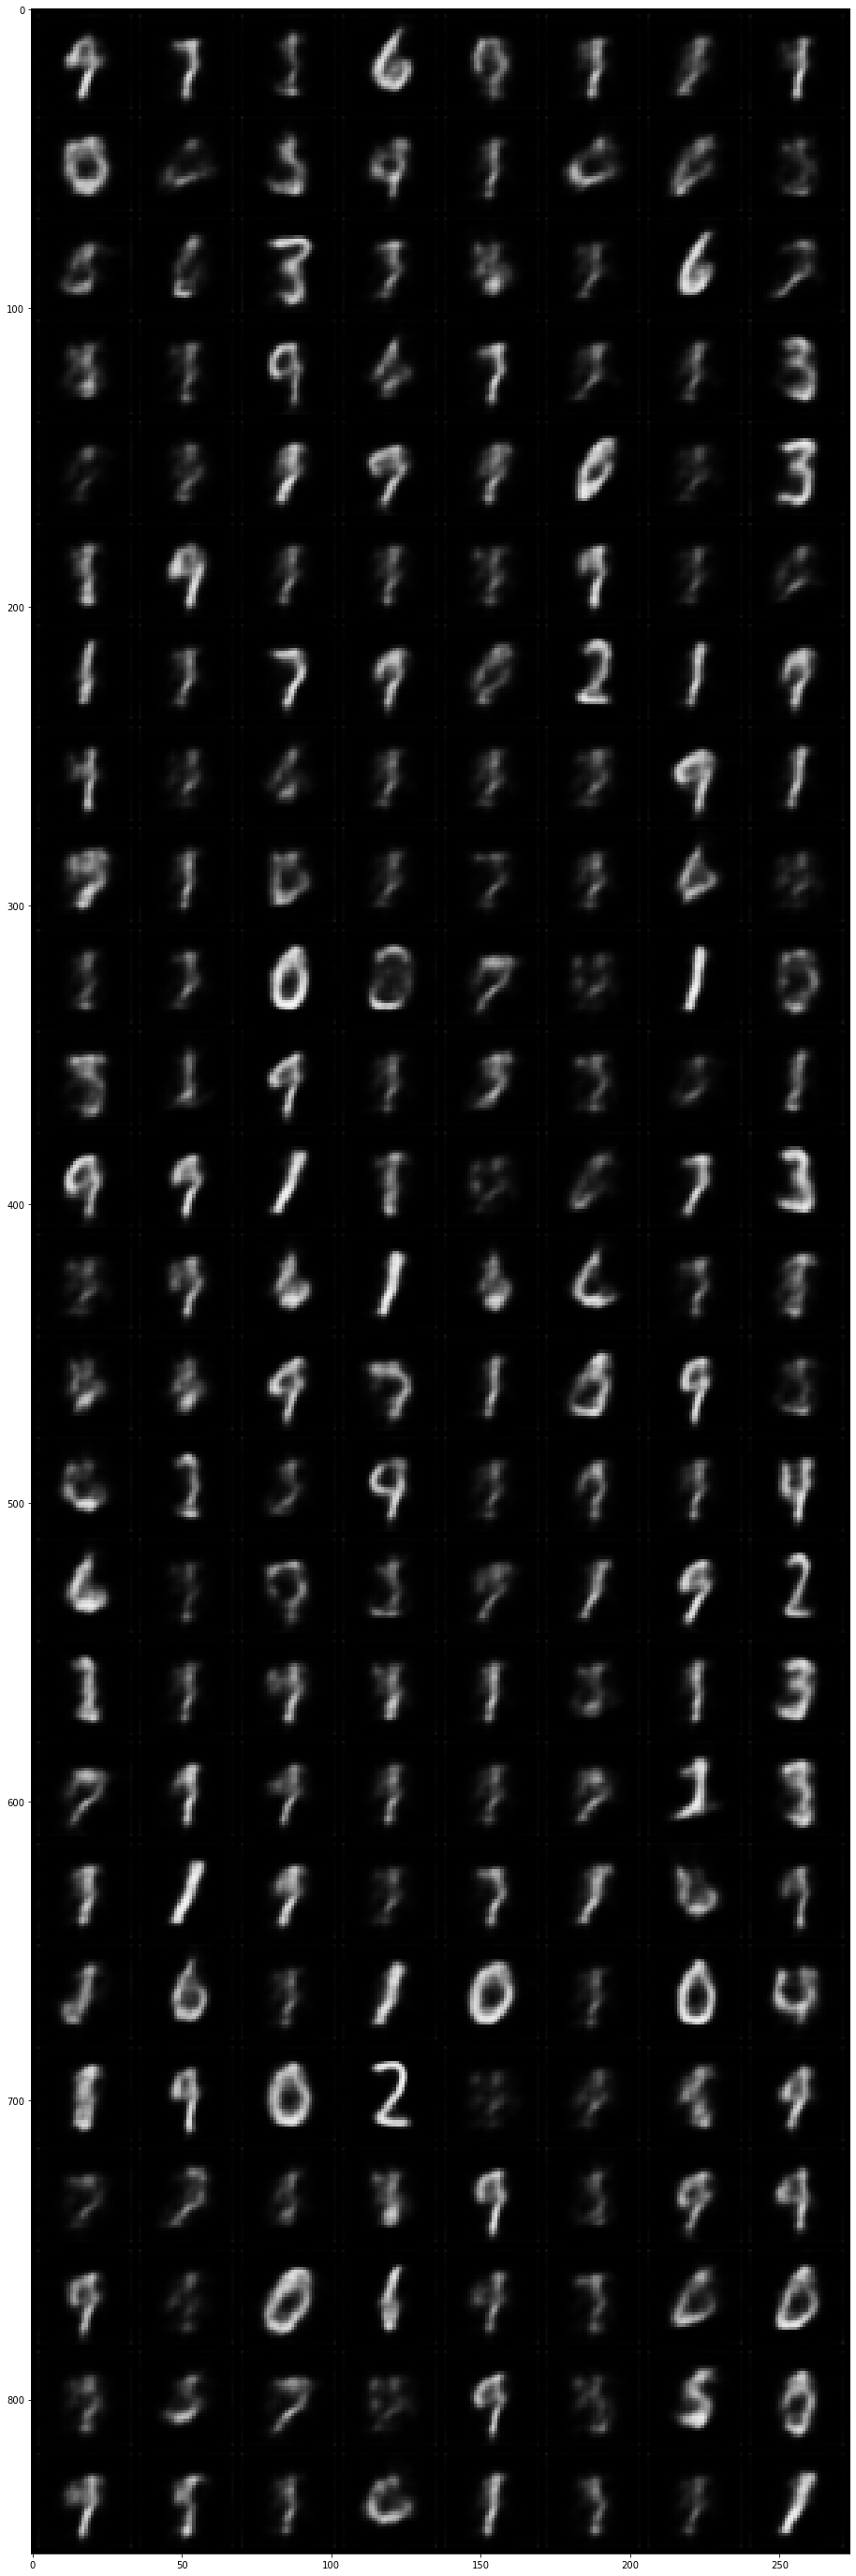

In [63]:
grid = torchvision.utils.make_grid(output_test,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

## Adversarial Example

In [121]:
choice = 1

In [122]:
img = images[choice].unsqueeze(0)

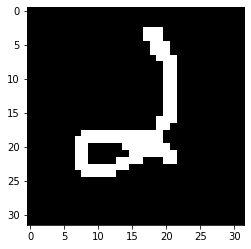

In [123]:
plt.imshow(img.squeeze(),cmap="gray")

In [125]:
adv = 3

In [70]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [126]:
target = torch.tensor([adv])

In [113]:
def create_adversarial_img(img,model,target,criterion):
    
#     img.requires_grad_()

    x,y = img.shape[2:]
    
    for i in range(x):
        for j in range(y):
            
            adv_img = img.clone()
            if adv_img[0,0,i,j]==0:
                adv_img[0,0,i,j] = 1
            else:
                adv_img[0,0,i,j] = 0
                
            with torch.no_grad():
                _,_,_,pred = model(adv_img,labels)
                
            loss = criterion(pred,target)
            
            if loss<1.55:
                return adv_img
            
    
    print("Sorry, no adversarial examples were found")
            
            
    
    

In [127]:
adv_img = create_adversarial_img(img,model,target,criterion)

Sorry, no adversarial examples were found


In [128]:
x = img.clone()

In [133]:
model.eval()
x.requires_grad_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], requires_grad=True)

In [135]:
with torch.no_grad():
    _,_,_,pred = model(x,labels)

In [138]:
loss = criterion(pred,target)

In [140]:
x.backward()

RuntimeError: grad can be implicitly created only for scalar outputs